# Introduction to Computer Vision: Plant Seedlings Classification

###**By Lakshmi Devesh Kumar**

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
import os
import random
import math
import cv2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from google.colab.patches import cv2_imshow

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the image file
images = np.load('/content/drive/MyDrive/Python Course/Project 8/images.npy')

In [ ]:
#Load the Labels.csv file into dataset
labels = pd.read_csv('/content/drive/MyDrive/Python Course/Project 8/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
images.shape

(4750, 128, 128, 3)

In [ ]:
labels.shape

(4750, 1)

### unique labels

In [ ]:
np.unique(labels)

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

In [ ]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Plotting random images from each of the categories

In [ ]:
def plot_images(images,labels):                                              # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(15, 10))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

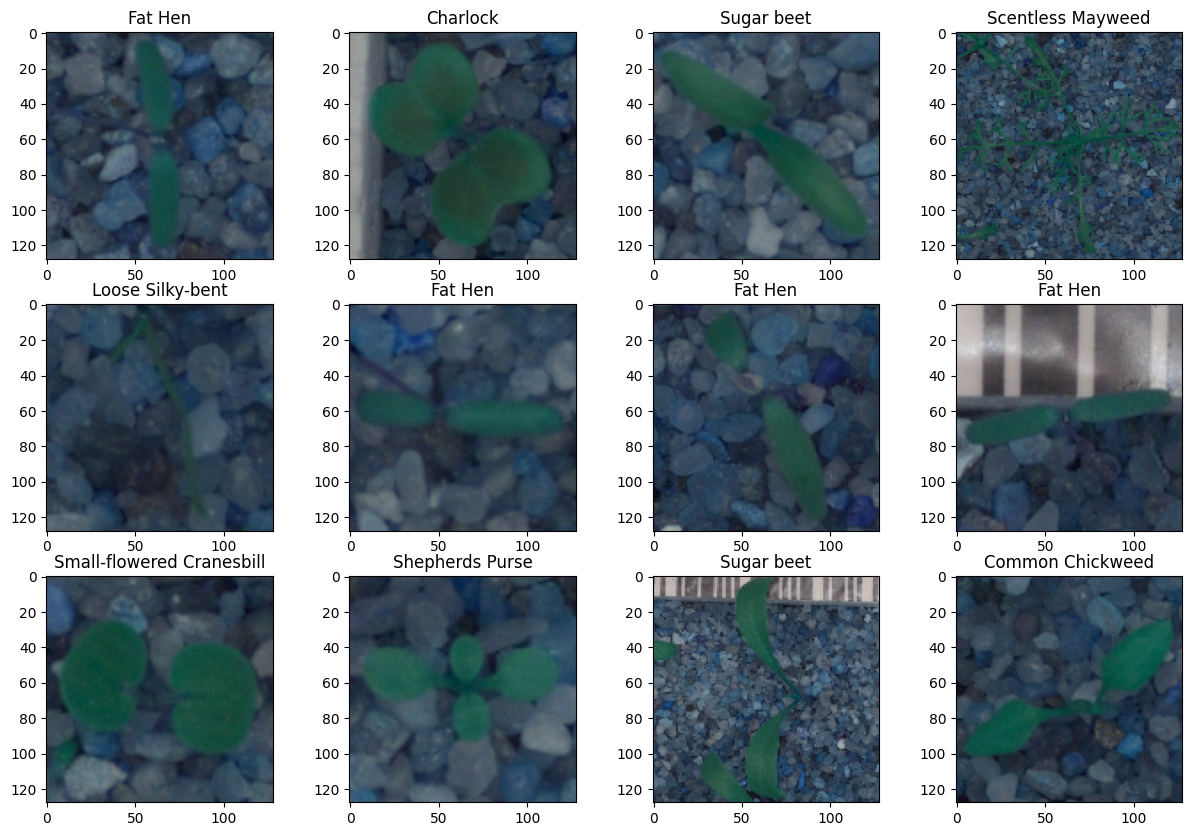

In [ ]:
plot_images(images, labels)

### Checking the distribution of the labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

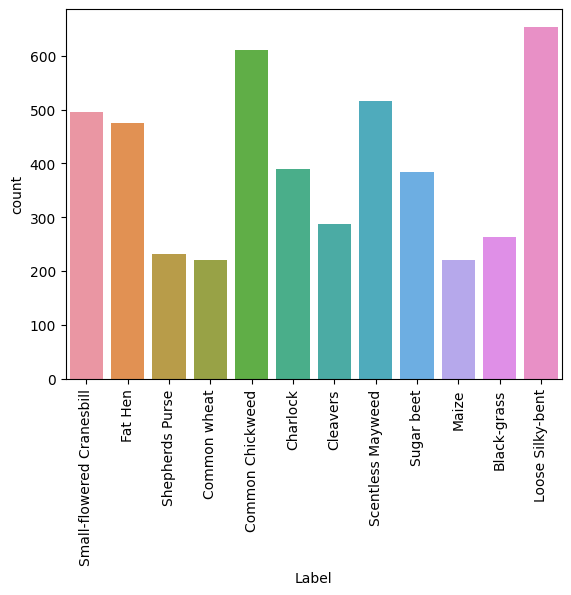

In [ ]:
sns.countplot(data=labels, x='Label')

plt.xticks(rotation='vertical')

### Questions and Answers

**1. How are these different category plant images different from each other?**


<b>Answer:</b>
* We can see that sizes of the images differ from each other.
* We can also see that some of the images are blurry while others are sharp.
* So resizing and blurring all the images might help to make the images more uniform. These steps are performed in the following sections.

**2. Is the dataset provided an imbalance? (Check with using bar plots)**

<b> Answer: </b>

* The dataset is quite imbalanced.
* There are more than 600 images of the Loose Silky-bent images seedling in the dataset.
* There are just over 200 images of Maize seedling.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

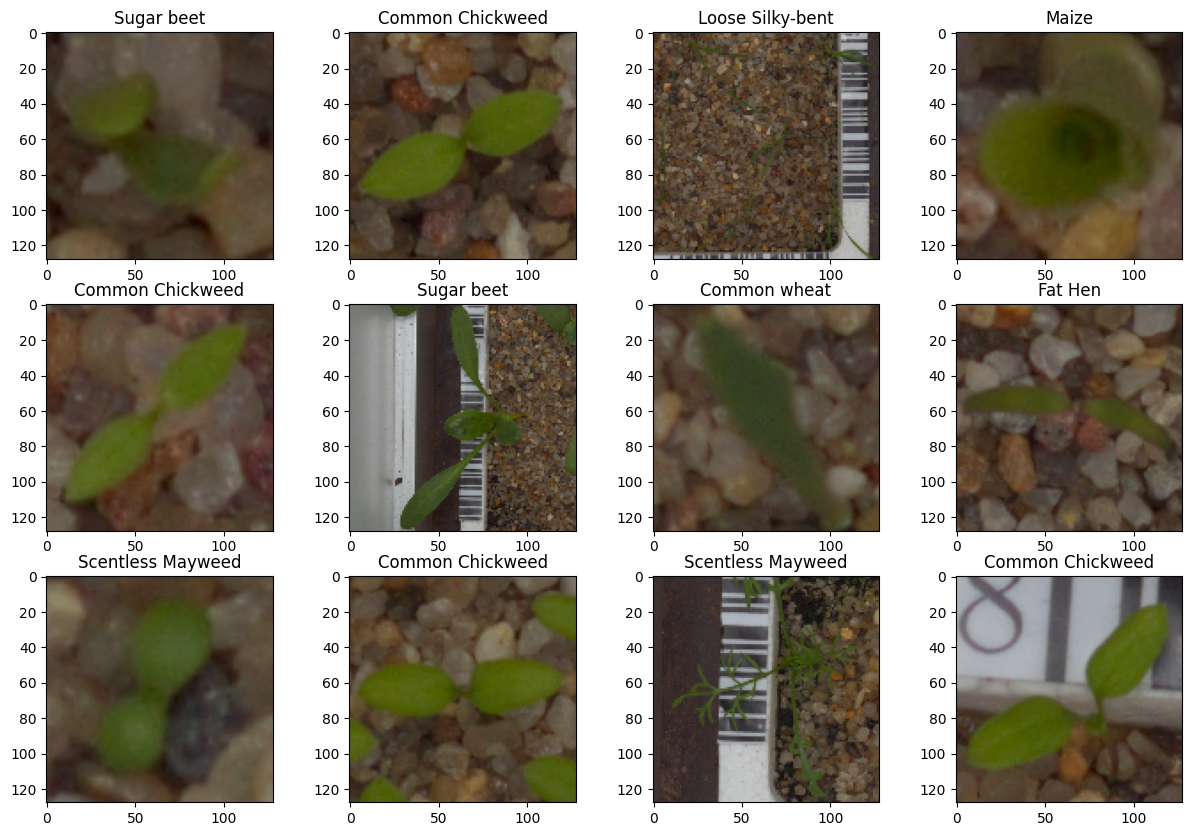

In [ ]:
# Check out the RGB images after conversion.
plot_images(images, labels)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

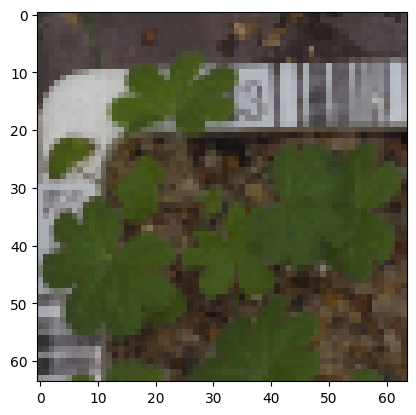

In [ ]:
plt.imshow(images_decreased[3])

### Visualizing images using Gaussian Blur

In [ ]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize=(3,3),sigmaX = 0))

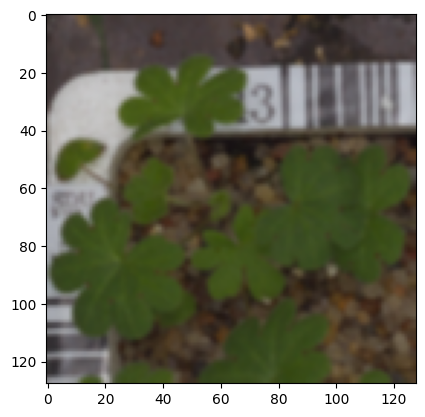

In [ ]:
plt.imshow(images_gb[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
# Check the shape of train data
print(X_train.shape,y_train.shape)


(3847, 64, 64, 3) (3847, 1)


In [ ]:
# Check the shape of validation data
print(X_val.shape,y_val.shape)


(428, 64, 64, 3) (428, 1)


In [ ]:
# Check the shape of test data
print(X_test.shape,y_test.shape)

(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [ ]:
# Convert y_train labels from names to one hot vectors using labelBinarizer.
enc = LabelBinarizer()
y_train_enc = enc.fit_transform(y_train)
print(y_train_enc.shape)

(3847, 12)


In [ ]:
# Convert y_val labels from names to one hot vectors using labelBinarizer.
y_val_enc = enc.fit_transform(y_val)
print(y_val_enc.shape)

(428, 12)


In [ ]:
# Convert y_trest labels from names to one hot vectors using labelBinarizer.
y_test_enc = enc.fit_transform(y_test)
print(y_test_enc.shape)

(475, 12)


### Data Normalization

In [ ]:
# Normalizing the image pixels
X_train_nor = X_train.astype('float32')/255.0
X_val_nor = X_val.astype('float32')/255.0
X_test_nor = X_test.astype('float32')/255.0

## Model Building

### Model 1

In [ ]:
# Clearing backend

backend.clear_session()

In [ ]:
# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model1 = Sequential()

# Adding the first layer of the convolutional layer with 128 filters and kernell size of 3x3, padding 'same' to provide the same number of
#  output size as input size and activation=relu
model1.add(Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)))

#Adding max pooling to reduce the size of output of first convolutional layer
model1.add(MaxPooling2D((2, 2), padding='same'))

# Adding the first layer of the convolutional layer with 64 filters and kernell size of 3x3, padding 'same' and activation=relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))

# Adding the first layer of the convolutional layer with 32 filters and kernell size of 3x3, padding 'same' and activation=relu
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))

# Complete the code to flatten the output
model1.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# Complete the code to add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Complete the code to use the Adam Optimizer
opt=Adam()

# Complete the code to Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

#### Fitting the model on the train data

In [ ]:
# Complete the code to fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_nor, y_train_enc,
            epochs=30,
            validation_data=(X_val_nor,y_val_enc),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.4518 - accuracy: 0.1172 - val_loss: 2.4329 - val_accuracy: 0.1285 - 13s/epoch - 111ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3261 - accuracy: 0.2051 - val_loss: 2.0617 - val_accuracy: 0.3411 - 1s/epoch - 11ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0628 - accuracy: 0.2948 - val_loss: 1.8384 - val_accuracy: 0.3902 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9293 - accuracy: 0.3138 - val_loss: 1.7395 - val_accuracy: 0.4065 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8384 - accuracy: 0.3301 - val_loss: 1.6734 - val_accuracy: 0.4439 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7517 - accuracy: 0.3481 - val_loss: 1.6417 - val_accuracy: 0.3995 - 1s/epoch - 9ms/step
Epoch 7/30
121/121 - 1s - loss: 1.7268 - accuracy: 0.3728 - val_loss: 1.4897 - val_accuracy: 0.5421 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6444 - accuracy: 0.3915 - val_loss: 1.3300 - val_accuracy: 0.5561 - 1s/epoch - 9ms/step
Epoch 9/30
121/12

#### Model Evaluation

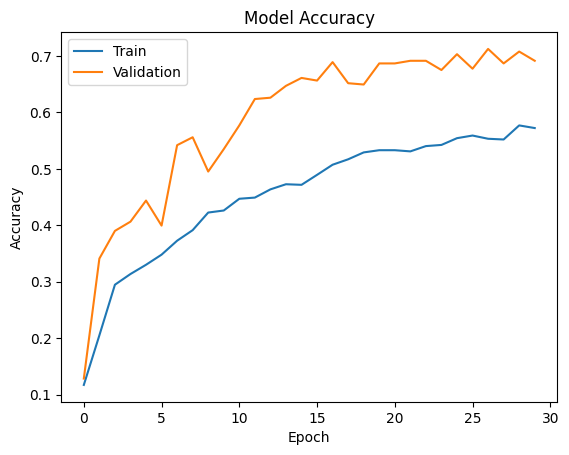

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Evaluating the model on test data

In [ ]:
accuracy = model1.evaluate(X_test_nor, y_test_enc, verbose=2)

15/15 - 0s - loss: 1.0672 - accuracy: 0.6674 - 190ms/epoch - 13ms/step


#### Generating the predictions using test data

In [ ]:
# Here we would get the output as probablities for each category
y_pred1=model1.predict(X_test_nor)

15/15 [==============================] - 0s 3ms/step


In [ ]:
y_pred1

array([[2.3324169e-16, 3.0263118e-11, 6.4942416e-14, ..., 2.5783844e-02,
        4.4815398e-11, 2.7980863e-05],
       [1.5336784e-11, 2.0517872e-01, 2.6530677e-02, ..., 1.1876956e-01,
        5.7661211e-01, 4.0209092e-02],
       [2.9532191e-10, 5.0046746e-02, 1.7439859e-01, ..., 1.9684641e-02,
        3.2180294e-01, 2.5643098e-01],
       ...,
       [2.5308812e-01, 1.4014223e-08, 1.4211368e-04, ..., 3.1334515e-08,
        1.2473230e-09, 2.4779502e-04],
       [1.1499730e-07, 4.2986320e-04, 3.4384889e-04, ..., 1.5950685e-02,
        3.6135748e-06, 2.6938086e-02],
       [7.8508478e-13, 6.6455039e-03, 3.9950979e-04, ..., 7.8130126e-01,
        2.6253499e-02, 8.9493074e-02]], dtype=float32)

#### Plotting the Confusion Matrix

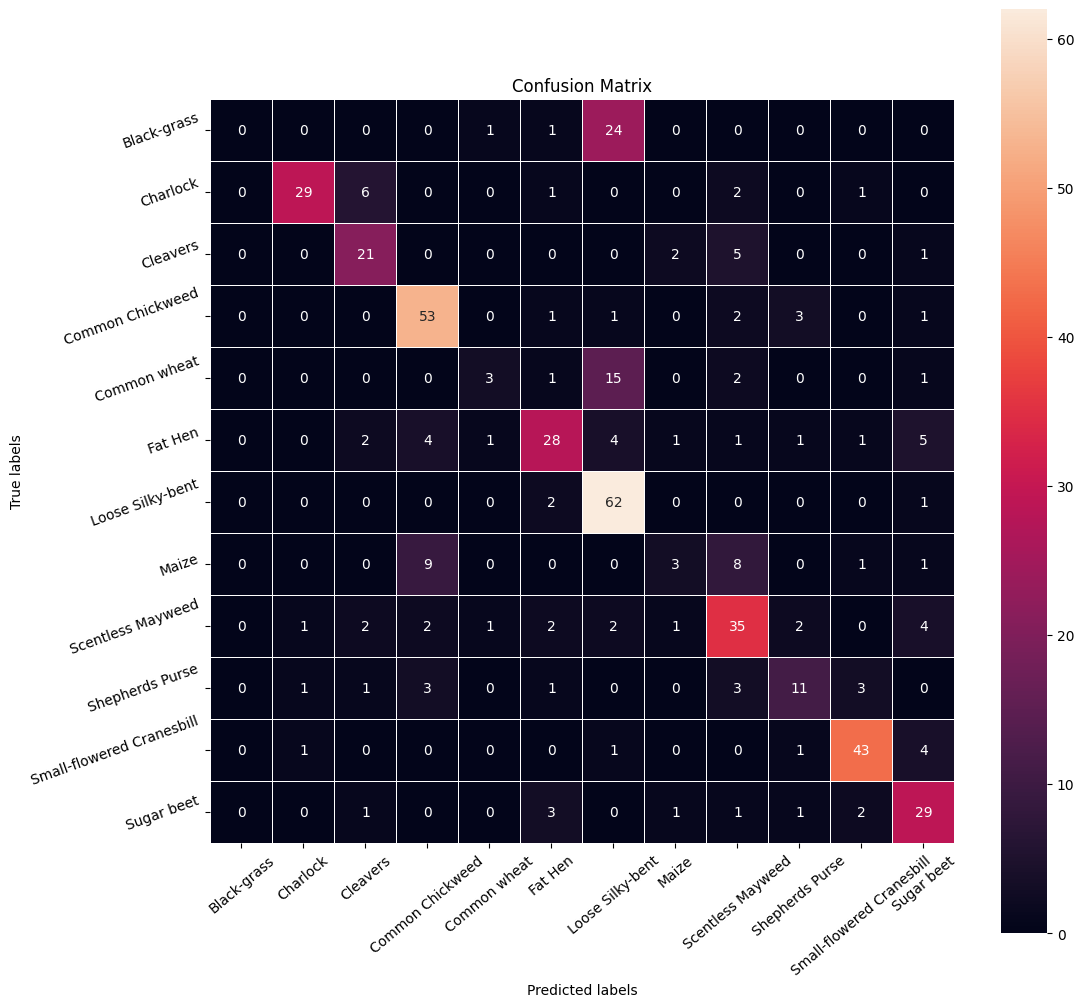

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg1=np.argmax(y_pred1,axis=1)
y_test_arg1=np.argmax(y_test_enc,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg1,y_pred_arg1)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [ ]:
print(classification_report((y_pred_arg1), y_test_arg1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.74      0.91      0.82        32
           2       0.72      0.64      0.68        33
           3       0.87      0.75      0.80        71
           4       0.14      0.50      0.21         6
           5       0.58      0.70      0.64        40
           6       0.95      0.57      0.71       109
           7       0.14      0.38      0.20         8
           8       0.67      0.59      0.63        59
           9       0.48      0.58      0.52        19
          10       0.86      0.84      0.85        51
          11       0.76      0.62      0.68        47

    accuracy                           0.67       475
   macro avg       0.58      0.59      0.56       475
weighted avg       0.77      0.67      0.70       475



### Observations:
* Model 1 is a base convolution neural network model.
* The train, validation and test accuracies for model 1 are 57%, 69% and about 67% respectively.
* We can perform Data Augmentation method to overcome the imbalance problem and improve the performance as shown in Model 2 below.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

### Model 2

In [ ]:
# Clearing backend

backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# Intializing a sequential model
model2 = Sequential()

# Complete the code to add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Complete the code to add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Complete the code to add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Complete the code to add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Complete the code to initialize Adam Optimimzer
opt=Adam()
# Complete the code to Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

#### Fitting the model on the train data

In [ ]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 80
# Batch size
batch_size = 64

history2 = model2.fit(train_datagen.flow(X_train_nor,y_train_enc,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_nor.shape[0] // batch_size,
                                       validation_data=(X_val_nor,y_val_enc),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/80
60/60 [==============================] - 11s 124ms/step - loss: 2.1336 - accuracy: 0.2514 - val_loss: 2.3732 - val_accuracy: 0.2220 - lr: 0.0010
Epoch 2/80
60/60 [==============================] - 8s 127ms/step - loss: 1.6914 - accuracy: 0.4068 - val_loss: 2.3017 - val_accuracy: 0.1939 - lr: 0.0010
Epoch 3/80
60/60 [==============================] - 5s 78ms/step - loss: 1.4740 - accuracy: 0.4745 - val_loss: 2.2132 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 4/80
60/60 [==============================] - 5s 90ms/step - loss: 1.4275 - accuracy: 0.4975 - val_loss: 2.0742 - val_accuracy: 0.2850 - lr: 0.0010
Epoch 5/80
60/60 [==============================] - 6s 104ms/step - loss: 1.2814 - accuracy: 0.5443 - val_loss: 1.8358 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 6/80
60/60 [==============================] - 5s 79ms/step - loss: 1.1799 - accuracy: 0.5860 - val_loss: 1.6690 - val_accuracy: 0.5491 - lr: 0.0010
Epoch 7/80
60/60 [==============================] - 7s 114ms/step - loss

#### Model Evaluation

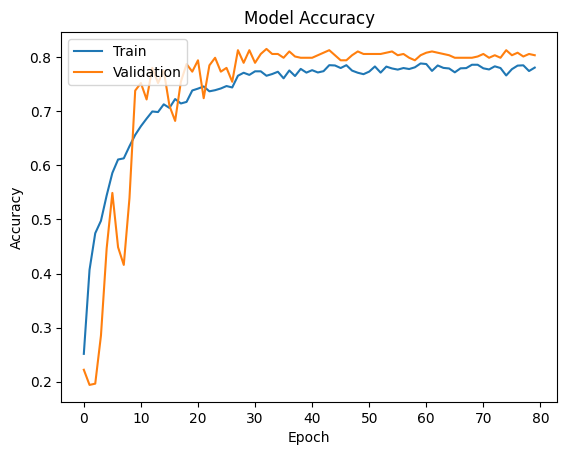

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Evaluate the model on test data

In [ ]:
# Evaluate the model on test data
accuracy = model2.evaluate(X_test_nor, y_test_enc, verbose=2)

15/15 - 0s - loss: 0.6788 - accuracy: 0.7937 - 216ms/epoch - 14ms/step


#### Generating the predictions using test data

In [ ]:
# Complete the code to obtain the output probabilities
y_pred2=model2.predict(X_test_nor)

15/15 [==============================] - 0s 3ms/step


#### Plotting the Confusion Matrix

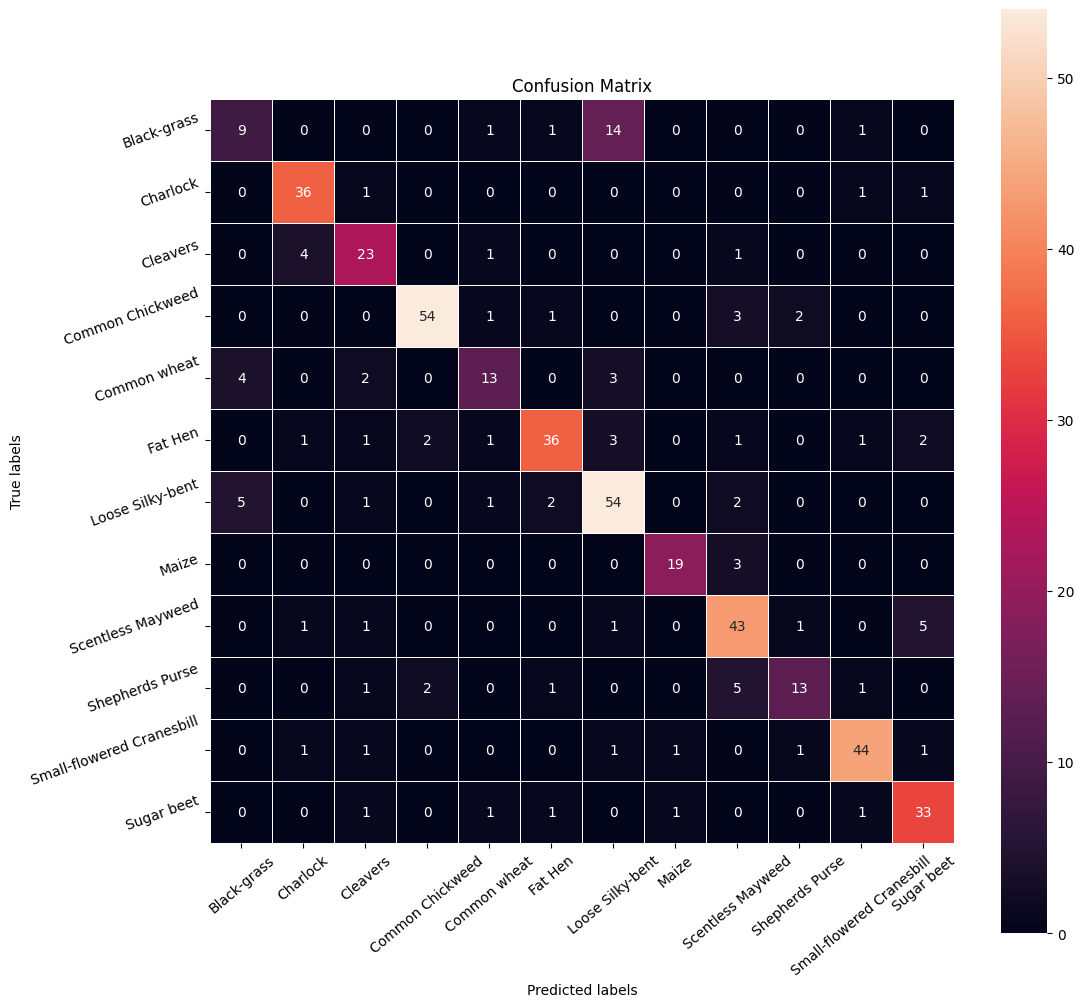

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred2
y_pred_arg2=np.argmax(y_pred2,axis=1)
y_test_arg2=np.argmax(y_test_enc,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg2,y_pred_arg2)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [ ]:
print(classification_report((y_pred_arg2), y_test_arg2))

              precision    recall  f1-score   support

           0       0.35      0.50      0.41        18
           1       0.92      0.84      0.88        43
           2       0.79      0.72      0.75        32
           3       0.89      0.93      0.91        58
           4       0.59      0.68      0.63        19
           5       0.75      0.86      0.80        42
           6       0.83      0.71      0.77        76
           7       0.86      0.90      0.88        21
           8       0.83      0.74      0.78        58
           9       0.57      0.76      0.65        17
          10       0.88      0.90      0.89        49
          11       0.87      0.79      0.82        42

    accuracy                           0.79       475
   macro avg       0.76      0.78      0.76       475
weighted avg       0.81      0.79      0.80       475



### Observations:
* Model 2 is a CNN model with data augmentation.
* The train, validation and test accuracies for model 2 are 78%, 80% and about 79% respectively.
* There is no sign of overfitting or underfitting as all the train, validation and test accuracies are very similar.
* The performance has greatly improved when compared to that of model1.
* We can perform Transfer learning using the VGG16 model to check if we can improve the performance further as shown in Model 3 below.

### Transfer Learning using VGG16

### Model 3

In [ ]:
# Clearing backend

backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
model3 = Sequential()

# Adding the convolutional part of the VGG16 model
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense output layer
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(16, activation='relu'))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model3.add(Dense(12, activation='softmax'))

opt=Adam()

#Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14780988 (56.38 MB)
Trainable params: 6630

#### Fitting the model on the train data

In [ ]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 130
# Batch size
batch_size = 64

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history3 = model3.fit(train_datagen.flow(X_train_nor,y_train_enc,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_nor.shape[0] // batch_size,
                                       validation_data=(X_val_nor,y_val_enc),
                                       verbose=1,use_multiprocessing=True
                      )

Epoch 1/130
60/60 [==============================] - 18s 251ms/step - loss: 2.4332 - accuracy: 0.1483 - val_loss: 2.3031 - val_accuracy: 0.2220
Epoch 2/130
60/60 [==============================] - 11s 183ms/step - loss: 2.2392 - accuracy: 0.2469 - val_loss: 2.1132 - val_accuracy: 0.3061
Epoch 3/130
60/60 [==============================] - 13s 205ms/step - loss: 2.0668 - accuracy: 0.2881 - val_loss: 1.9793 - val_accuracy: 0.3411
Epoch 4/130
60/60 [==============================] - 11s 185ms/step - loss: 1.9562 - accuracy: 0.3135 - val_loss: 1.9098 - val_accuracy: 0.3668
Epoch 5/130
60/60 [==============================] - 12s 190ms/step - loss: 1.8704 - accuracy: 0.3384 - val_loss: 1.8484 - val_accuracy: 0.3621
Epoch 6/130
60/60 [==============================] - 10s 169ms/step - loss: 1.8186 - accuracy: 0.3524 - val_loss: 1.7928 - val_accuracy: 0.3738
Epoch 7/130
60/60 [==============================] - 11s 185ms/step - loss: 1.7671 - accuracy: 0.3722 - val_loss: 1.7406 - val_accuracy:

#### Model Evaluation

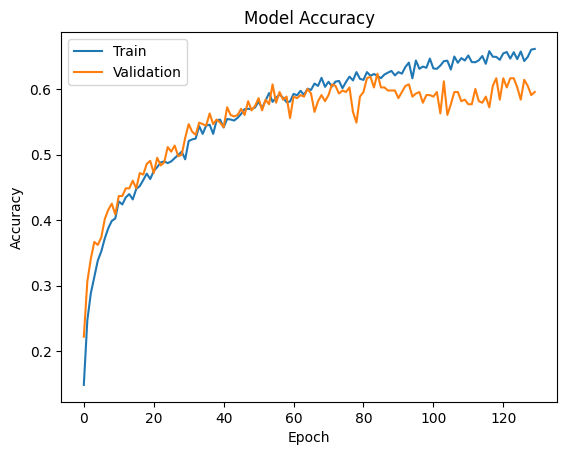

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Evaluate the model on test data

In [ ]:
accuracy = model3.evaluate(X_test_nor, y_test_enc, verbose=2)

15/15 - 1s - loss: 1.3217 - accuracy: 0.6147 - 918ms/epoch - 61ms/step


#### Generating the predictions using test data

In [ ]:
# Complete the code to obtain the output probabilities
y_pred3=model3.predict(X_test_nor)

15/15 [==============================] - 0s 13ms/step


#### Plotting the Confusion Matrix

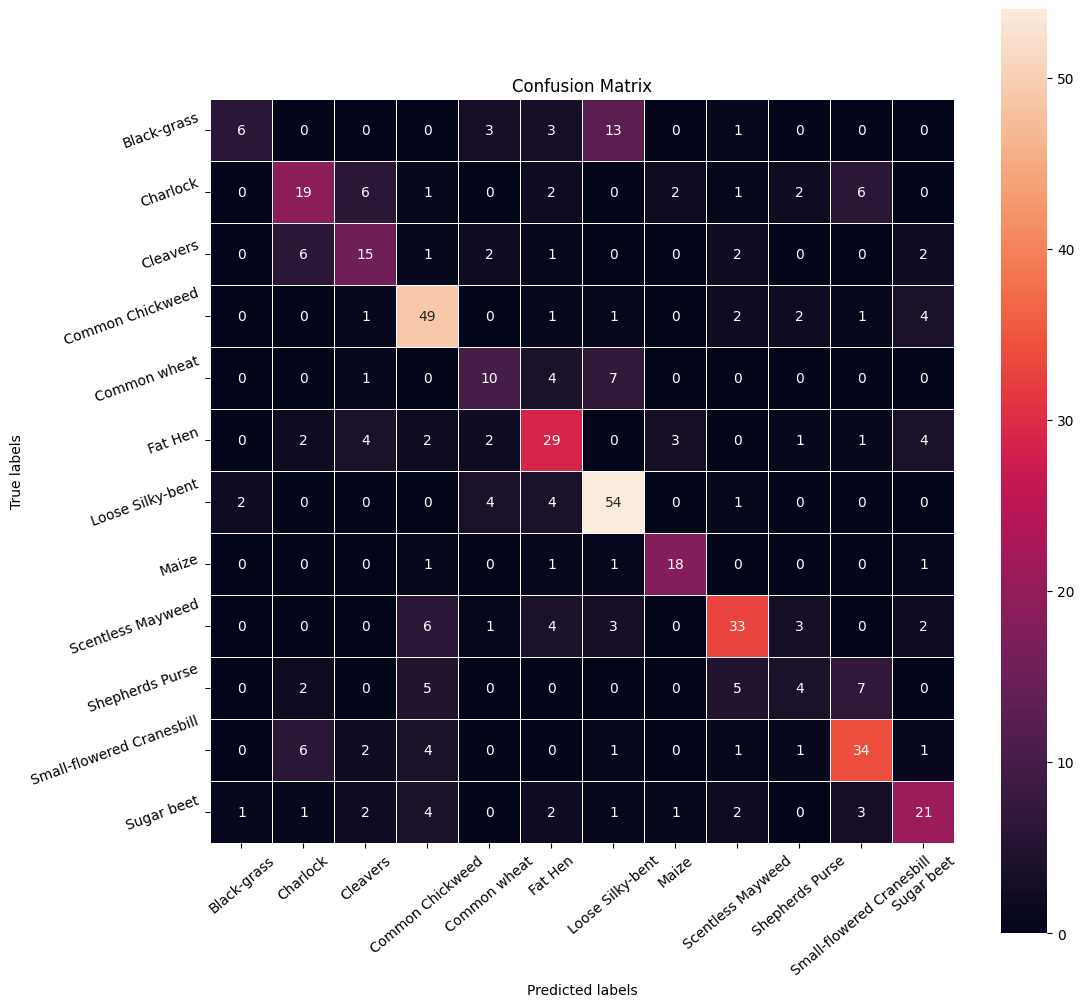

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred3
y_pred_arg3=np.argmax(y_pred3,axis=1)
y_test_arg3=np.argmax(y_test_enc,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg3,y_pred_arg3)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [ ]:
print(classification_report((y_pred_arg3), y_test_arg3))

              precision    recall  f1-score   support

           0       0.23      0.67      0.34         9
           1       0.49      0.53      0.51        36
           2       0.52      0.48      0.50        31
           3       0.80      0.67      0.73        73
           4       0.45      0.45      0.45        22
           5       0.60      0.57      0.59        51
           6       0.83      0.67      0.74        81
           7       0.82      0.75      0.78        24
           8       0.63      0.69      0.66        48
           9       0.17      0.31      0.22        13
          10       0.68      0.65      0.67        52
          11       0.55      0.60      0.58        35

    accuracy                           0.61       475
   macro avg       0.57      0.59      0.56       475
weighted avg       0.65      0.61      0.63       475



### Observations:
* Model 3 is a CNN model with Transfer learning VGG.
* The train, validation and test accuracies for model 3 are 66%, 60% and about 61% respectively.
* The performance has reduced when compared to that of model1 and model2.



## Final Model

We can observe from the confusion matrix of all the models that Model 2 which is the model with Data Augmentation was the best model because it predicted the majority of the classes better than the other models.

So, we can consider Model 2 as the final model and visualize the predictions as shown below

### Visualizing the prediction

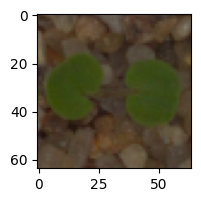

1/1 [==============================] - 0s 82ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


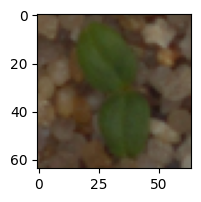

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Cleavers']
True Label Cleavers


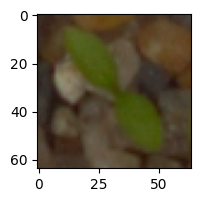

1/1 [==============================] - 0s 26ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


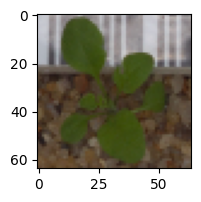

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data


## Predict the image #2 from test data using model 2
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()

# reshaping the input image as we are only trying to predict using a single image
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_nor[2].reshape(1,64,64,3)))))
# using inverse_transform() to get the output label from the output vector
print('True Label', enc.inverse_transform(y_test_enc)[2])


## Predict the image #33 from test data using model 2
plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()

# reshaping the input image as we are only trying to predict using a single image
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_nor[33].reshape(1,64,64,3)))))
# using inverse_transform() to get the output label from the output vector
print('True Label', enc.inverse_transform(y_test_enc)[33])


## Predict the image #59 from test data using model 2
plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()

# reshaping the input image as we are only trying to predict using a single image
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_nor[59].reshape(1,64,64,3)))))
# using inverse_transform() to get the output label from the output vector
print('True Label', enc.inverse_transform(y_test_enc)[59])


## Predict the image #36 from test data using model 2
plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()

# reshaping the input image as we are only trying to predict using a single image
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_nor[36].reshape(1,64,64,3)))))
# using inverse_transform() to get the output label from the output vector
print('True Label', enc.inverse_transform(y_test_enc)[36])

## Actionable Insights

* We can observe that among the 3 models, the best one is model 2 which is the CNN with data augmentation which acheived the test accuracy of 79%.
* In model 1, we have a base CNN Model which acheived a test accuracy of 67%, this model is underfitted as Validation accuracy is 69% and the train accuracy is only 57%.
* In model 2, we have a CNN Model with data augmenation which acheived a test accuracy of 79%, the Validation accuracy is 80% and the train accuracy is 78%. There is no overfitting or underfitting problem in this model.
* For model 3, we have used the transfer learning VGG16 model. The test accuracy of this model is 61%,  Validation accuracy is 60% and the train accuracy is only 66%.
* The transfer learning VGG16 model does not give a better outcome. But, data augmentation improves the accuracy of the base CNN model.

In [ ]:
# Comparison of train, validation and test accuracies of the above 3 models.
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['57%','78%','66%'],'Validation Accuracy':['69%','80%','60%'],'Test Accuracy':['67%','79%','61%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,57%,69%,67%
1,CNN Model with Data Augmentation,78%,80%,79%
2,Transfer Learning Model,66%,60%,61%


## Business Recommendations

* These models can be further improved by training with different filter sizes and different number of filters.
* More Data Augmentation parameters can be set up to improve the accuracy.
* More epochs, callbacks and early stopping can be used to improve the performance.
* We can use more hidden layers in the transfer learning VGG16 model with more epochs to improve the performance.
* We can also try other Transfer Learning models which could provide better classification.

_____